In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import glob
from PIL import Image, ImageDraw
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import seaborn as sns

### Evaluation Results

In [2]:
results_dir = '/deep/group/aihc-bootcamp-spring2020/localize/eval_results'

In [3]:
ious = pd.read_csv(f'{results_dir}/gradcam/test_gradcam_ensemble_merged_iou_prob_threshold.csv')

In [4]:
method = 'gradcam'
model_type = 'ensemble'
phase = 'test'
save_dir = f'{results_dir}/{method}/{phase}_{method}_{model_type}_merged_summary_threshold.csv'
gradcam_threshold = pd.read_csv(save_dir)
gradcam_ptgame = pd.read_csv(f'{results_dir}/{method}/ptgame_gradcam_summary.csv')

In [5]:
save_dir = f'{results_dir}/{method}/{phase}_{method}_{model_type}_merged_summary_prob_threshold.csv'
gradcam_prob = pd.read_csv(save_dir)

In [6]:
save_dir = f'/deep/group/aihc-bootcamp-spring2020/localize/eval_results/human'
vietnam = pd.read_csv(f'{save_dir}/test_human_merged_summary.csv')
vietnam_ptgame = pd.read_csv(f'{save_dir}/ptgame_vietnam_summary.csv')

In [7]:
vietnam_ptgame

,name,lower,mean,upper
0,Enlarged Cardiomediastinum,0.927,0.952,0.975
1,Cardiomegaly,0.944,0.972,0.994
2,Lung Lesion,0.636,0.855,1.000
3,Airspace Opacity,0.508,0.560,0.611
4,Edema,0.679,0.773,0.863
5,Consolidation,0.355,0.513,0.674
6,Atelectasis,0.820,0.870,0.919
7,Pneumothorax,1.000,1.000,1.000
8,Pleural Effusion,0.638,0.719,0.803
9,Support Devices,0.905,0.934,0.959


In [8]:
hit_diff = gradcam_ptgame.sort_values(['name']).rename(columns = {'mean':'gradcam'})
hit_diff['human'] = (vietnam_ptgame.sort_values(['name']))['mean'].tolist()
hit_diff['perct_diff'] = (hit_diff['human']-hit_diff['gradcam'])/hit_diff['human']*100
hit_diff = hit_diff.sort_values(['perct_diff'],ascending = False).reset_index()

In [9]:
iou_diff = gradcam_prob.rename(columns = {'mean':'gradcam'})
iou_diff['human'] = vietnam['mean']
iou_diff['perct_diff'] = (iou_diff['human']-iou_diff['gradcam'])/iou_diff['human']*100
iou_diff = iou_diff.sort_values(['perct_diff'],ascending = False).reset_index()

In [151]:
iou_diff.round(3)

,index,name,lower,gradcam,upper,human,perct_diff
0,6,Lung Lesion,0.010,0.027,0.047,0.424,93.632
1,5,Enlarged Cardiomediastinum,0.153,0.169,0.185,0.564,70.035
2,8,Pneumothorax,0.047,0.124,0.206,0.393,68.448
3,9,Support Devices,0.132,0.143,0.152,0.438,67.352
4,2,Cardiomegaly,0.242,0.275,0.307,0.712,61.376
5,4,Edema,0.139,0.174,0.211,0.307,43.322
6,3,Consolidation,0.056,0.087,0.123,0.148,41.216
7,7,Pleural Effusion,0.130,0.158,0.188,0.213,25.822
8,0,Airspace Opacity,0.175,0.193,0.211,0.232,16.810
9,1,Atelectasis,0.126,0.145,0.163,0.122,-18.852


In [167]:
hit_diff[['name','human','gradcam','perct_diff']].round(3).to_csv('tables/hit.csv')

In [168]:
iou_diff[['name','human','gradcam','perct_diff']].round(3).to_csv('tables/iou.csv')

In [10]:
order_iou = iou_diff['name'].tolist()
order_hit = hit_diff['name'].tolist()

In [11]:
map_order = dict(zip(order_iou,vietnam.name))
vietnam = vietnam.sort_values(by=['name'], key=lambda x: x.map(map_order))
map_order_gradcam = dict(zip(order_iou,gradcam_prob.name))
gradcam_prob = gradcam_prob.sort_values(by=['name'], key=lambda x: x.map(map_order_gradcam))

In [12]:
gradcam_prob['method'] = 'Grad-CAM'
vietnam['method'] = 'Benchmark'
rad_ai_iou = pd.DataFrame()
rad_ai_iou = rad_ai_iou.append([gradcam_prob,vietnam])

In [14]:
rad_ai_iou.to_csv("tables/rad_ai_iou.csv")

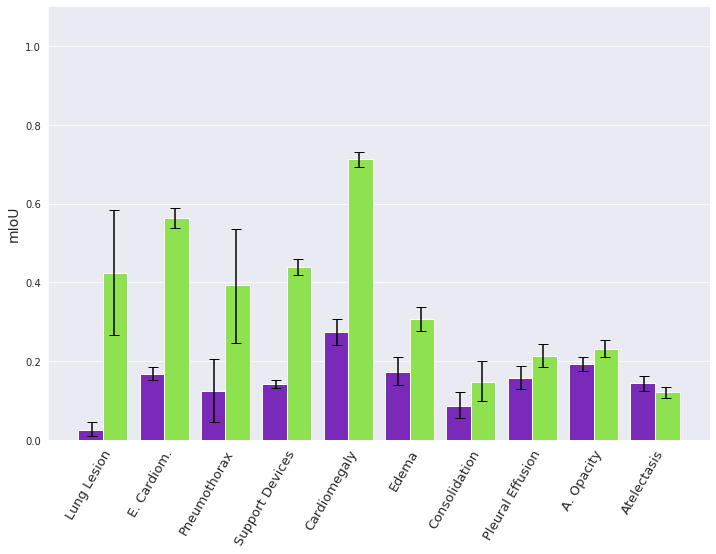

In [21]:
import matplotlib as mpc

lower = -vietnam['lower']+vietnam['mean']
upper = vietnam['upper']-vietnam['mean']
yerrs_vietnam = np.array([lower,upper])

lower = -gradcam_prob['lower']+gradcam_prob['mean']
upper = gradcam_prob['upper']-gradcam_prob['mean']
yerrs_gradcam = np.array([lower,upper])

task_labels = order_iou.copy()
task_labels[order_iou.index('Enlarged Cardiomediastinum')] = 'E. Cardiom.'
task_labels[order_iou.index('Airspace Opacity')] = 'A. Opacity'

colorway = ["#7e11d1","#8bfa37"]
plt.figure(figsize=(10,8))
g = sns.barplot(x="name", y="mean", hue = 'method',data=rad_ai_iou,palette = colorway, order = order_iou)
sns.set_style("darkgrid")
g.set_xticklabels(task_labels,fontsize=13,rotation=60,ha="right",rotation_mode="anchor")
plt.errorbar(np.arange(10)+0.18,iou_diff['human'], yerr=yerrs_vietnam, capsize=5,fmt=' ',c='black')
plt.errorbar(np.arange(10)-0.18,iou_diff['gradcam'], yerr=yerrs_gradcam, capsize=5,fmt=' ',c='black')
plt.tight_layout()
plt.legend(fontsize='xx-large')
leg_handles = g.get_legend_handles_labels()[0]
g.legend("",frameon=False)
# g.legend(leg_handles, ['Grad-CAM', 'Radiologists'],fontsize=13)
plt.xlabel('', fontsize=0)
plt.ylabel('mIoU', fontsize=14)
plt.ylim([0,1.1])
plt.savefig('fig2/update_figs/miou_human_ai_prob_threshold.png',dpi = 300)

In [15]:
vietnam_ptgame = pd.read_csv(f'{save_dir}/ptgame_vietnam_summary.csv')
gradcam_ptgame = pd.read_csv(f'{results_dir}/{method}/ptgame_gradcam_summary.csv')
map_order = hit_diff['name'].to_dict()
inv_map = {v: k for k, v in map_order.items()}
vietnam_ptgame = vietnam_ptgame.sort_values(by=['name'], key=lambda x: x.map(inv_map))
# map_order_gradcam = dict(zip(order_hit,gradcam_ptgame.name.tolist()))
gradcam_ptgame = gradcam_ptgame.sort_values(by=['name'], key=lambda x: x.map(inv_map))


In [16]:
gradcam_ptgame['method'] = 'Grad-CAM'
vietnam_ptgame['method'] = 'Benchmark'
rad_ai_hit = pd.DataFrame()
rad_ai_hit = rad_ai_hit.append([gradcam_ptgame,vietnam_ptgame])

In [18]:
rad_ai_hit.to_csv("tables/rad_ai_hit.csv")

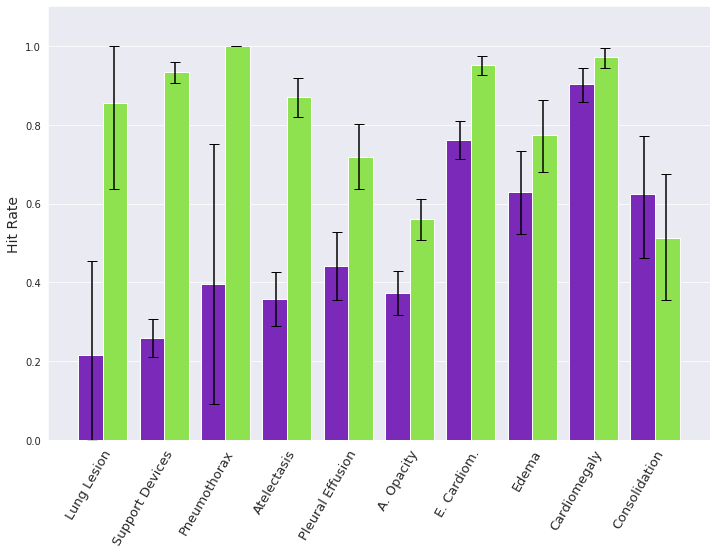

In [27]:
import matplotlib as mpc
lower = -vietnam_ptgame['lower']+vietnam_ptgame['mean']
upper = vietnam_ptgame['upper']-vietnam_ptgame['mean']
yerrs_vietnam = np.array([lower,upper])

lower = -gradcam_ptgame['lower']+gradcam_ptgame['mean']
upper = gradcam_ptgame['upper']-gradcam_ptgame['mean']
yerrs_gradcam = np.array([lower,upper])

task_labels = order_hit.copy()
task_labels[order_hit.index('Enlarged Cardiomediastinum')] = 'E. Cardiom.'
task_labels[order_hit.index('Airspace Opacity')] = 'A. Opacity'

colorway = ["#7e11d1","#8bfa37"]
plt.figure(figsize=(10,8))
g = sns.barplot(x="name", y="mean", hue = 'method',data=rad_ai_hit,palette = colorway, order = order_hit)
sns.set_style("darkgrid")
g.set_xticklabels(task_labels,fontsize=13,rotation=60,ha="right",rotation_mode="anchor")
plt.errorbar(np.arange(10)+0.18,hit_diff['human'], yerr=yerrs_vietnam, capsize=5,fmt=' ',c='black')
plt.errorbar(np.arange(10)-0.18,hit_diff['gradcam'], yerr=yerrs_gradcam, capsize=5,fmt=' ',c='black')
plt.tight_layout()
plt.legend(fontsize='xx-large')
leg_handles = g.get_legend_handles_labels()[0]
g.legend("",frameon=False)
# g.legend(leg_handles, ['Grad-CAM', 'Radiologists'],fontsize=13)
plt.xlabel('', fontsize=0)
plt.ylabel('Hit Rate', fontsize=14)
plt.ylim((0,1.1))
plt.savefig('fig2/update_figs/ptgame_human_ai.png',dpi = 300)